In [59]:
import copy
from collections.abc import Iterable
import functools
import itertools
import operator
from matplotlib import pyplot as plt

import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import numpy_ext as npe
import math
import random
from pprint import pprint
from scipy.optimize import curve_fit
from scipy.stats import poisson
from scipy.sparse import hstack, vstack, csr_matrix
import scipy

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.preprocessing import Normalizer, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
import joblib

import seaborn as sns
import utils
import sys

from config import demographics, vital_sign_vars, lab_vars, treatment_vars, vent_vars, guideline_vars, ffill_windows_clinical, SAMPLE_TIME_H
from config import fio2_bins, peep_bins, tv_bins

In [60]:
file = 'data/ope-wis-results.csv'
ope_wis = pd.read_csv(file)
REWARD_RANGE = (-100, 100)
RR_SIZE = max(REWARD_RANGE) - min(REWARD_RANGE)

In [61]:
ope_wis.loc[:, 'algorithm'] = ope_wis.algorithm.str.replace('behavior', 'IL')
ope_wis.loc[:, 'algorithm'] = ope_wis.algorithm.str.replace('observed', 'O')
ope_wis.loc[:, 'algorithm'] = ope_wis.algorithm.str.replace('softmax', 'QL')
ope_wis.loc[:, 'algorithm'] = ope_wis.algorithm.str.replace('greedy', 'G')
ope_wis['norm_scalar'] = ope_wis['scalar'] / RR_SIZE

In [62]:
ope_wis = ope_wis[ope_wis.algorithm != 'G']


In [63]:
# seeds = ope_wis.seed.unique()
# algorithms = ope_wis.algorithm.unique()
# settings = ope_wis.train_test.unique()
# shaping = ope_wis.shaping.unique()

# experiments = itertools.product(seeds, algorithms, settings)
cis_train = []
cis_test = []
for index, experiment in ope_wis.iterrows():
    mean = experiment['mean']
    if experiment['train_test'] == 'train':
        n = experiment['n_train']
        cis = cis_train
    elif experiment['train_test'] == 'test':
        n = experiment['n_test']
        cis = cis_test
    else:
        raise ValueError('Only train and test results supported for now')
    ci_low, ci_up = utils.var_to_ci_cheb(experiment['var'], mean, n)
    ci_low = max(ci_low, -100)
    ci_up = min(ci_up, 100)
    cis.append([experiment['seed'], experiment['algorithm'], experiment['safety'], experiment['norm_scalar'], mean, ci_low, ci_up, experiment['hcope5'], experiment['am']])

cis_test = pd.DataFrame(cis_test, columns=['seed', 'algorithm', 'safe', 'norm_scalar', 'mean', 'ci_l', 'ci_u', 'hcope5', 'am'])
cis_train = pd.DataFrame(cis_train, columns=['seed', 'algorithm', 'safe', 'norm_scalar', 'mean', 'ci_l', 'ci_u', 'hcope5', 'am'])

cis_test['setup'] = cis_test[['algorithm', 'norm_scalar', 'safe']].apply(lambda x: '-'.join(map(str, x)), axis=1)
cis_train['setup'] = cis_train[['algorithm', 'norm_scalar', 'safe']].apply(lambda x: '-'.join(map(str, x)), axis=1)

In [64]:
cis_train.groupby('setup')['mean'].mean(), cis_test.groupby('setup')['mean'].mean()

(setup
 IL-0.0-safe         -9.838134
 IL-0.0-unsafe        4.807540
 O-0.0-unsafe        26.369532
 QL-0.0-safe         68.300285
 QL-0.0-unsafe       84.178146
 QL-0.0005-safe      70.429864
 QL-0.0005-unsafe    75.832613
 QL-0.0025-safe      70.429864
 QL-0.0025-unsafe    75.832613
 QL-0.005-safe       70.346576
 QL-0.005-unsafe     75.929377
 QL-0.01-safe        70.414039
 QL-0.01-unsafe      75.943608
 QL-0.015-safe       70.427454
 QL-0.015-unsafe     75.963212
 QL-0.025-safe       70.617213
 QL-0.025-unsafe     75.836271
 QL-0.03-safe        68.092927
 QL-0.03-unsafe      76.143859
 QL-0.05-safe        41.617902
 QL-0.05-unsafe      74.550547
 Name: mean, dtype: float64,
 setup
 IL-0.0-safe          9.461028
 IL-0.0-unsafe       42.238648
 O-0.0-unsafe        27.424658
 QL-0.0-safe         47.818669
 QL-0.0-unsafe       30.518108
 QL-0.0005-safe      44.192151
 QL-0.0005-unsafe    29.129900
 QL-0.0025-safe      44.192151
 QL-0.0025-unsafe    29.129900
 QL-0.005-safe       49.213

In [65]:
cis_train.groupby('setup')['mean'].std(), cis_test.groupby('setup')['mean'].std()

(setup
 IL-0.0-safe         40.603779
 IL-0.0-unsafe       42.530598
 O-0.0-unsafe         0.733459
 QL-0.0-safe         34.284330
 QL-0.0-unsafe        0.931017
 QL-0.0005-safe      28.874039
 QL-0.0005-unsafe    26.659490
 QL-0.0025-safe      28.874039
 QL-0.0025-unsafe    26.659490
 QL-0.005-safe       28.830979
 QL-0.005-unsafe     26.687414
 QL-0.01-safe        28.869530
 QL-0.01-unsafe      26.693250
 QL-0.015-safe       28.876129
 QL-0.015-unsafe     26.701615
 QL-0.025-safe       28.993283
 QL-0.025-unsafe     26.645832
 QL-0.03-safe        31.173624
 QL-0.03-unsafe      26.257016
 QL-0.05-safe        56.545984
 QL-0.05-unsafe      26.346771
 Name: mean, dtype: float64,
 setup
 IL-0.0-safe         58.537143
 IL-0.0-unsafe        3.093159
 O-0.0-unsafe         2.301304
 QL-0.0-safe         59.482664
 QL-0.0-unsafe       53.678541
 QL-0.0005-safe      61.086408
 QL-0.0005-unsafe    54.322512
 QL-0.0025-safe      61.086408
 QL-0.0025-unsafe    54.322512
 QL-0.005-safe       57.279

In [66]:
for setup, means in cis_test.groupby('setup')['mean']:
    mean = means.mean()
    std = means.std()
    print(setup, mean, std)
    print(scipy.stats.norm.interval(.95, loc=mean, scale=std/math.sqrt(len(means))))

IL-0.0-safe 9.461028218 58.5371430172347
(-26.820002229383714, 45.74205866538371)
IL-0.0-unsafe 42.238647607999994 3.093158541661766
(40.32152330974761, 44.155771906252376)
O-0.0-unsafe 27.424658342999997 2.30130365466979
(25.99832177001133, 28.850994915988665)
QL-0.0-safe 47.818668626 59.482664100675485
(10.951608908160452, 84.68572834383954)
QL-0.0-unsafe 30.518108129 53.678540762854574
(-2.7515847771751716, 63.78780103517518)
QL-0.0005-safe 44.19215133770937 61.086407541359954
(6.331099402242565, 82.05320327317617)
QL-0.0005-unsafe 29.12989955283358 54.32251192905596
(-4.538923483100593, 62.79872258876776)
QL-0.0025-safe 44.19215133770937 61.086407541359954
(6.331099402242565, 82.05320327317617)
QL-0.0025-unsafe 29.12989955283358 54.32251192905596
(-4.538923483100593, 62.79872258876776)
QL-0.005-safe 49.213812993091516 57.27953078205358
(13.71224436163849, 84.71538162454453)
QL-0.005-unsafe 25.351552011620083 56.3039100989747
(-9.54533176704707, 60.24843579028723)
QL-0.01-safe 49.26

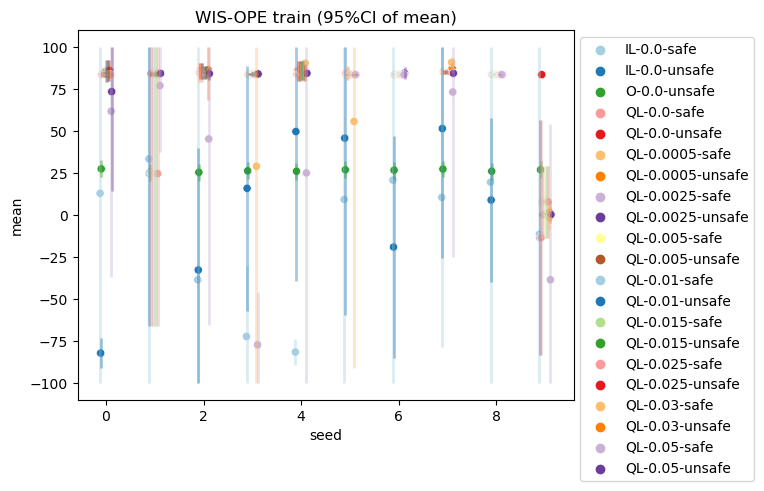

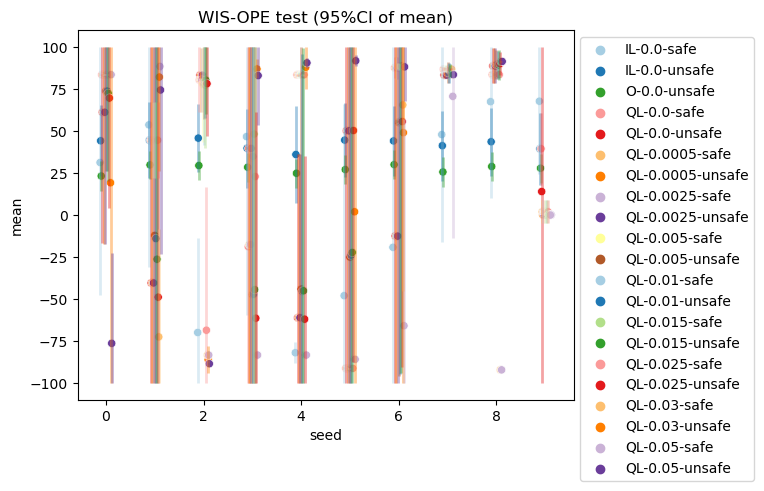

In [67]:
def get_x_offsets(n_settings, max_width =.25):
    width = max_width / n_settings
    if n_settings % 2 == 1:
        left = [width * i for i in range(-math.floor(n_settings / 2.0), 0)]
        right = [width * i for i in range(0, math.ceil(n_settings / 2.0))]
        return left + right
    elif n_settings % 2 == 0:
        left = [width * i + (width/2.0) for i in range(-math.floor(n_settings / 2.0), 0)]
        right = [width * i - (width/2.0) for i in range(2, math.ceil(n_settings / 2.0)+1)]
        return left + [width/2.0,] + right
    else:
        raise ValueError('modulo is 1 nor 0 for input {}'.format(n_settings))

def pointplot(ci_data, title, y='mean'):
    ci_data['_plot_x'] = ci_data['seed']
    hue_order = sorted(ci_data.setup.unique())
    cpal = sns.color_palette("Paired", n_colors=len(hue_order)+2)
    offsets = get_x_offsets(len(hue_order))
    colors = []
    color_i = 0
    for i, hue in enumerate(hue_order):
        if '-unsafe' in hue and color_i % 2 == 0:
            color_i += 1
        colors.append(cpal[color_i])
        ci_data.loc[ci_data.setup == hue, '_plot_x'] = ci_data.loc[ci_data.setup == hue, '_plot_x'] + offsets[i]
        color_i += 1
    sns.scatterplot(data=ci_data, x='_plot_x', y=y, hue='setup', hue_order=hue_order, palette=colors)
    plt.xlabel('seed')
    plt.legend(loc=2, bbox_to_anchor=(1.0,1.0))
    plt.title(title)
    return colors, hue_order
    
def pointplot_errbar(ci_data, title, y='mean', errbar=('ci_l', 'ci_u')):
    cpal, hue_order = pointplot(ci_data, title=title, y=y)
    linewidth = 2
#     ci_data['_plot_x_line'] = ci_data['_plot_x'] + linewidth / 2
    for seed in ci_data['seed'].unique():
        for i, setup in enumerate(hue_order):
            point_data = ci_data[(ci_data.seed == seed) & (ci_data.setup == setup)]
            plt.vlines(x=point_data['_plot_x'], ymin=point_data[errbar[0]], ymax=point_data[errbar[1]], colors=cpal[i], linewidths=linewidth, alpha=0.4)

pointplot_errbar(cis_train, "WIS-OPE train (95%CI of mean)")
plt.show()
pointplot_errbar(cis_test, 'WIS-OPE test (95%CI of mean)')

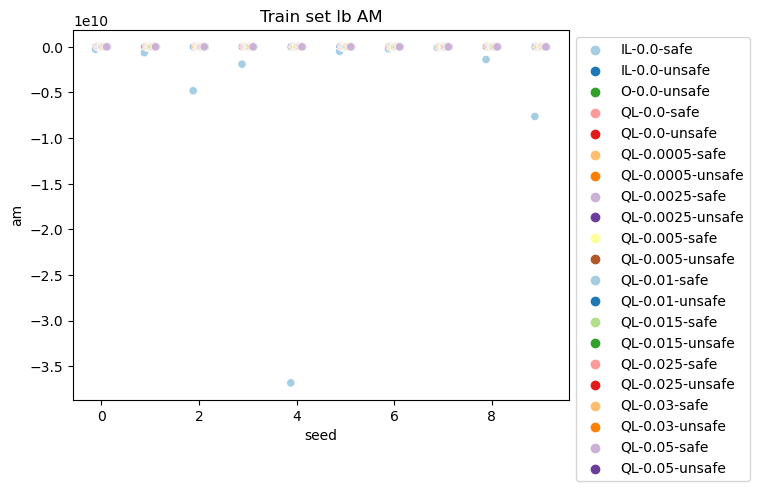

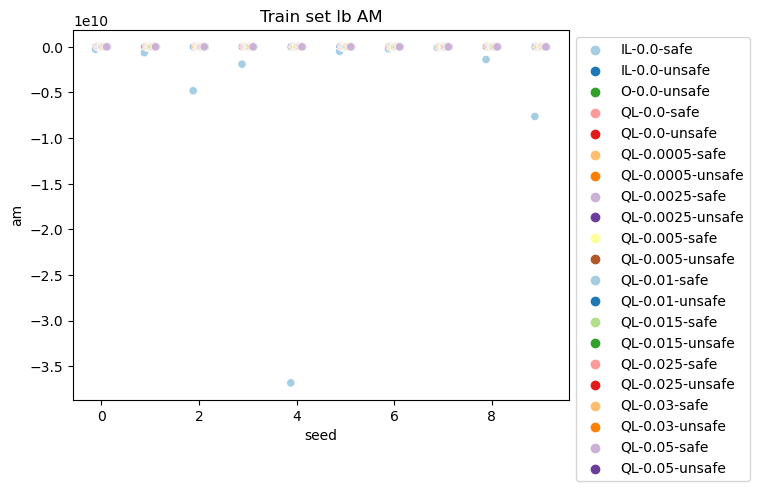

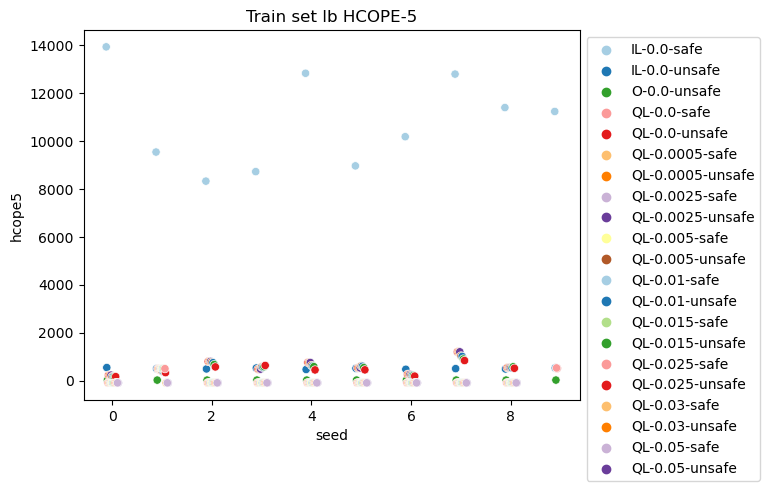

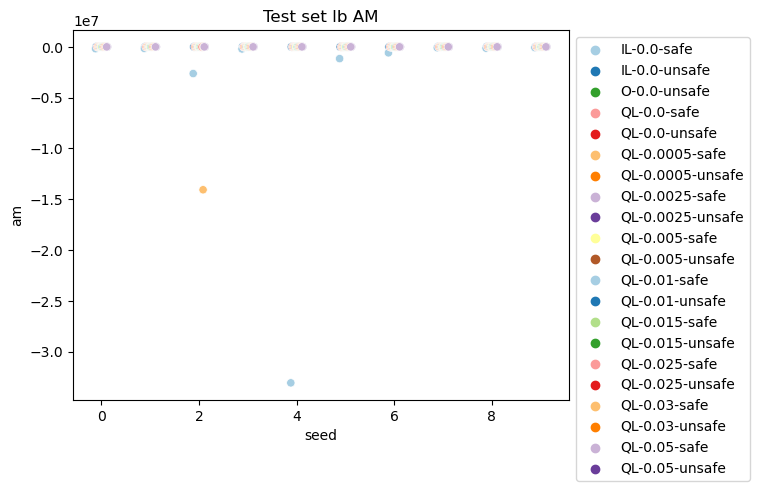

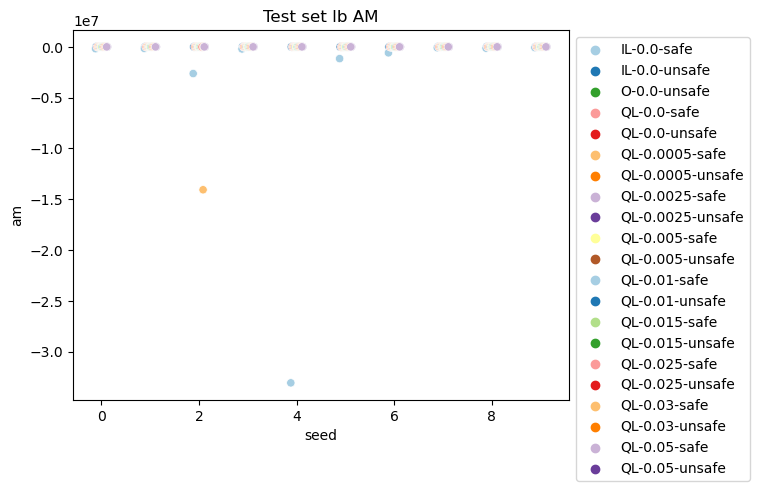

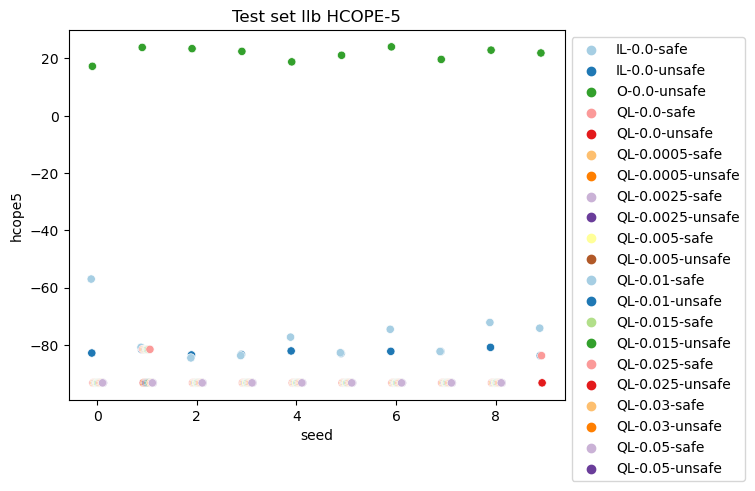

In [68]:
_ = pointplot(cis_train, 'Train set lb AM', 'am')
plt.show()
_ = pointplot(cis_train[cis_train.setup != 'behavior-safe'], 'Train set lb AM', 'am')
plt.show()
_ = pointplot(cis_train, 'Train set lb HCOPE-5', 'hcope5')
plt.show()
_ = pointplot(cis_test, 'Test set lb AM', 'am')
plt.show()
_ = pointplot(cis_test[cis_test.setup != 'behavior-safe'], 'Test set lb AM', 'am')
plt.show()
_ = pointplot(cis_test, 'Test set llb HCOPE-5', 'hcope5')
plt.show()


Text(0.5, 0.98, 'WIS OPE 95%CI of mean')

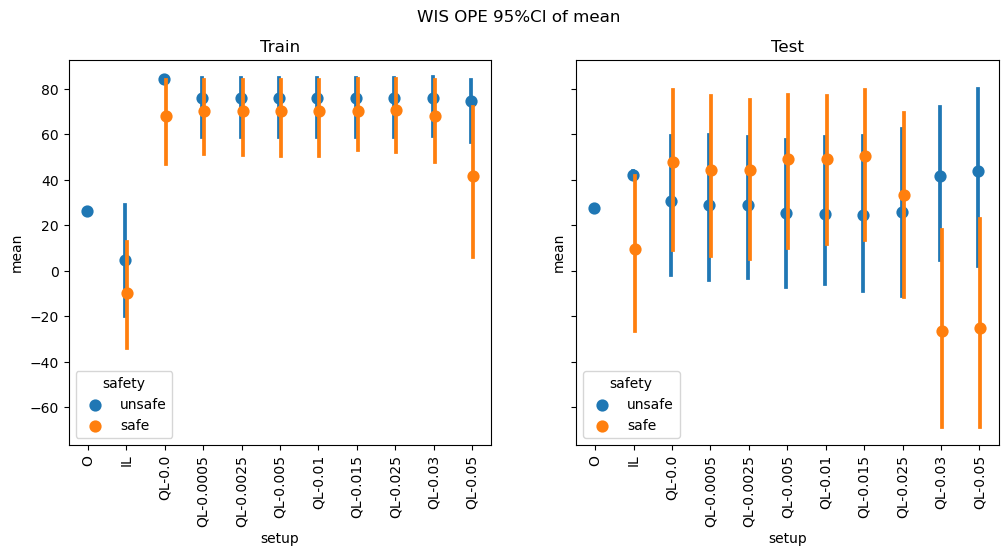

In [69]:
def to_setup(row):
    rnp = row.to_numpy()
    alg, scalar = rnp[0], rnp[1]
    if alg in {'O', 'IL'}:
        return alg
    else:
        return '{}-{}'.format(alg, scalar)

def setup_key(setup):
    order = pd.Series([float('-inf'),] * len(setup))
    order[setup == 'IL'] = 0
    order[setup.str.contains('G')] = setup.str.split('-').str[1].astype('float') * 200 + 1
    order[setup.str.contains('QL')] = setup.str.split('-').str[1].astype('float') * 200 + 2
    return order

ope_wis['setup'] = ope_wis[['algorithm', 'norm_scalar']].apply(to_setup, axis=1)
assert ope_wis.groupby(['setup','safety','train_test']).size().nunique() == 1, "All experiments should have be run the same # times"

plot_data = ope_wis.sort_values('setup', key=setup_key)
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12,5))
hue_order=sorted(plot_data.safety.unique(), reverse=True)
sns.pointplot(data=plot_data[plot_data.train_test == 'train'], x='setup', y='mean', hue='safety', hue_order=hue_order, join=False, dodge=True, ax=ax[0])
sns.pointplot(data=plot_data[plot_data.train_test == 'test'], x='setup', y='mean', hue='safety', hue_order=hue_order, join=False, dodge=True, ax=ax[1])
ax[0].set_title('Train')
ax[1].set_title('Test')
ax[0].tick_params(axis='x', rotation=90)
ax[1].tick_params(axis='x', rotation=90)
plt.suptitle('WIS OPE 95%CI of mean')

Text(0.5, 0.98, 'WIS OPE distribution')

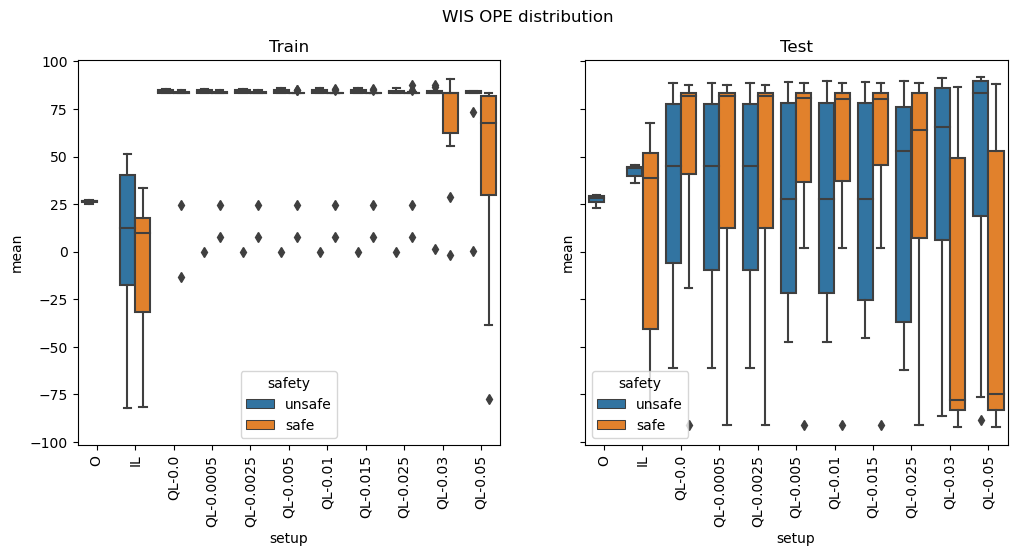

In [70]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12,5))
sns.boxplot(data=plot_data[plot_data.train_test == 'train'], x='setup', y='mean', hue='safety', hue_order=hue_order, ax=ax[0])
sns.boxplot(data=plot_data[plot_data.train_test == 'test'], x='setup', y='mean', hue='safety', hue_order=hue_order, ax=ax[1])
ax[0].set_title('Train')
ax[1].set_title('Test')
ax[0].tick_params(axis='x', rotation=90)
ax[1].tick_params(axis='x', rotation=90)

plt.suptitle('WIS OPE distribution')